# C. Elegans Deconvolution

**Work in progress**

Deconvolution of multi-channel [C. Elegans](http://bigwww.epfl.ch/deconvolution/bio/) dataset.

**Reference**<br>
D. Sage, L. Donati, F. Soulez, D. Fortun, G. Schmit, A. Seitz, R. Guiet, C. Vonesch, M. Unser
DeconvolutionLab2: An Open-Source Software for Deconvolution Microscopy
Methods - Image Processing for Biologists, 115, 2017.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nb import utils as nbutils 
from skimage import io
from scipy.stats import describe
from skimage.exposure import rescale_intensity
from tfdecon import data as tfd_data

In [99]:
from collections import OrderedDict

def load_celegans():
    """Get data for "C. Elegans" dataset"""
    
    acqs = OrderedDict()
    for ch in ['CY3', 'FITC', 'DAPI']:
        print('Loading:', nbutils._path('celegans/CElegans-{}/*.tif'.format(ch)))
        img_obs = tfd_data.load_img_stack(nbutils._path('celegans/CElegans-{}/*.tif'.format(ch)))
        img_psf = tfd_data.load_img_stack(nbutils._path('celegans/PSF-CElegans-{}/*.tif'.format(ch)))
        acqs[ch] = tfd_data.Acquisition(data=img_obs, kernel=img_psf)
    
    return acqs

def torgb(img, dtype):
    # Convert image list to array; returns (c, z, x, y)
    img = io.concatenate_images(img)
    
    # Ensure this analysis specific method is operating on the expected data type
    assert img.dtype == dtype, 'Expecting {} images, found {} instead'.format(dtype, img.dtype)
    
    # Concatenate and swap axes to (z, x, y, c)
    img = np.swapaxes(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2), 2, 3)
    
    return img

In [100]:
acqs = load_celegans()

Loading: C:\Users\User\data\deconvolution\data\celegans/CElegans-CY3/*.tif
Loading: C:\Users\User\data\deconvolution\data\celegans/CElegans-FITC/*.tif
Loading: C:\Users\User\data\deconvolution\data\celegans/CElegans-DAPI/*.tif


In [57]:
acqs['CY3'].shape()

{'actual': None, 'data': (104, 712, 672), 'kernel': (104, 712, 672)}

In [58]:
from scipy.stats import describe
for ch in acqs:
    print(ch, ': ', describe(acqs[ch].data.ravel()))

CY3 :  DescribeResult(nobs=49760256, minmax=(215, 2842), mean=999.7357257768127, variance=366893.5949394481, skewness=0.4276883403137024, kurtosis=-1.3198812347654247)
FITC :  DescribeResult(nobs=49760256, minmax=(209, 2929), mean=661.6911196558153, variance=111310.51265064703, skewness=0.4886892101746819, kurtosis=-0.7464241176109296)
DAPI :  DescribeResult(nobs=49760256, minmax=(206, 2687), mean=588.6275371252109, variance=87306.64087066457, skewness=0.6127404387738372, kurtosis=-0.37379257220038875)


In [67]:
img_rgb = rescale_intensity(torgb([acqs[ch].data for ch in acqs], np.uint16), out_range=(0, 255))
describe(img_rgb.ravel())

DescribeResult(nobs=149280768, minmax=(0, 255), mean=50.445352913779224, variance=1934.5488668894557, skewness=1.1027538511507757, kurtosis=0.5157380627007262)

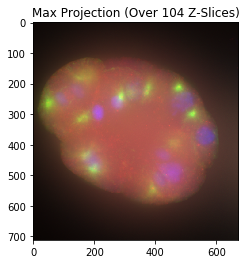

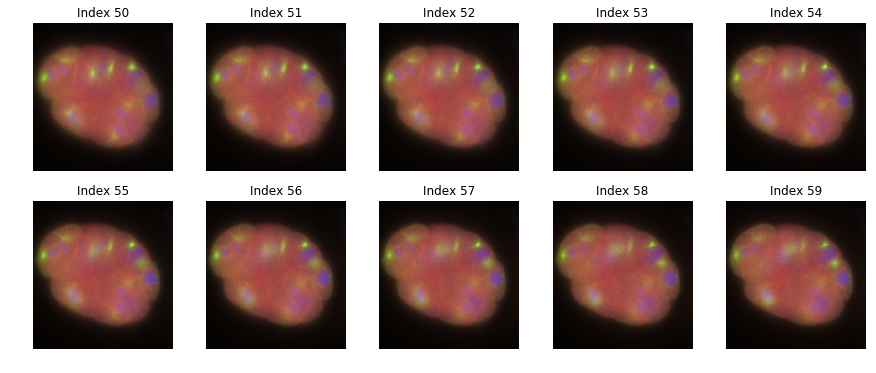

In [68]:
nbutils.plot_img_preview(img_rgb, zstart=50, zstop=60)

In [85]:
%%time
import tensorflow as tf
from tfdecon import restoration as tfd_restoration

niter = 200
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3).initialize()

res = {ch: algo.run(acqs[ch], niter=niter) for ch in acqs}

Wall time: 1min 26s


In [82]:
res_rgb = rescale_intensity(torgb([res[ch].data for ch in acqs], np.float32), out_range=(0., 1.))
describe(res_rgb.ravel())

DescribeResult(nobs=149280768, minmax=(0.0, 1.0), mean=0.0031132584, variance=0.0011641952, skewness=15.216543197631836, kurtosis=261.10269408789503)

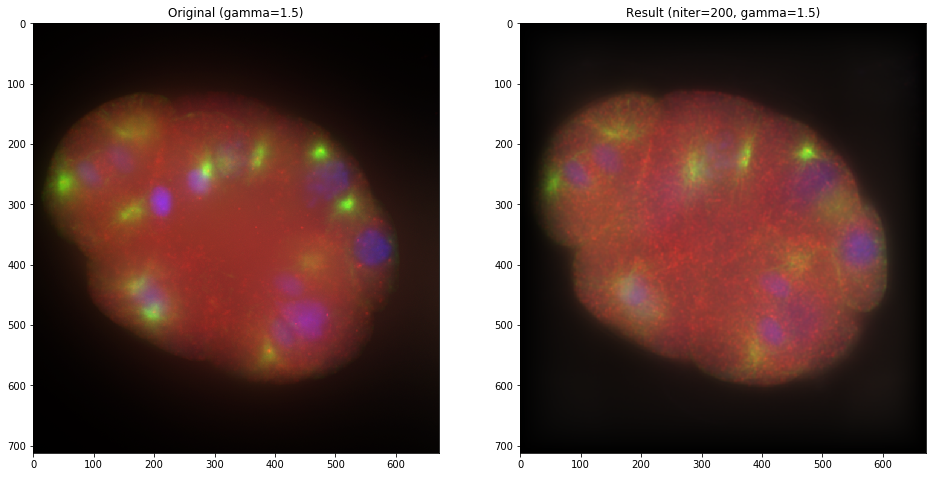

In [98]:
from skimage.exposure import adjust_gamma
gamma = 1.5
def prep(img):
    img = rescale_intensity(img.max(axis=0).astype(np.float32), out_range=(0., 1.))
    return adjust_gamma(img, gamma=gamma)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((16, 16))
axs[0].imshow(prep(img_rgb))
axs[0].set_title('Original (gamma={})'.format(gamma))
axs[1].imshow(prep(res_rgb))
axs[1].set_title('Result (niter={}, gamma={})'.format(niter, gamma))
None

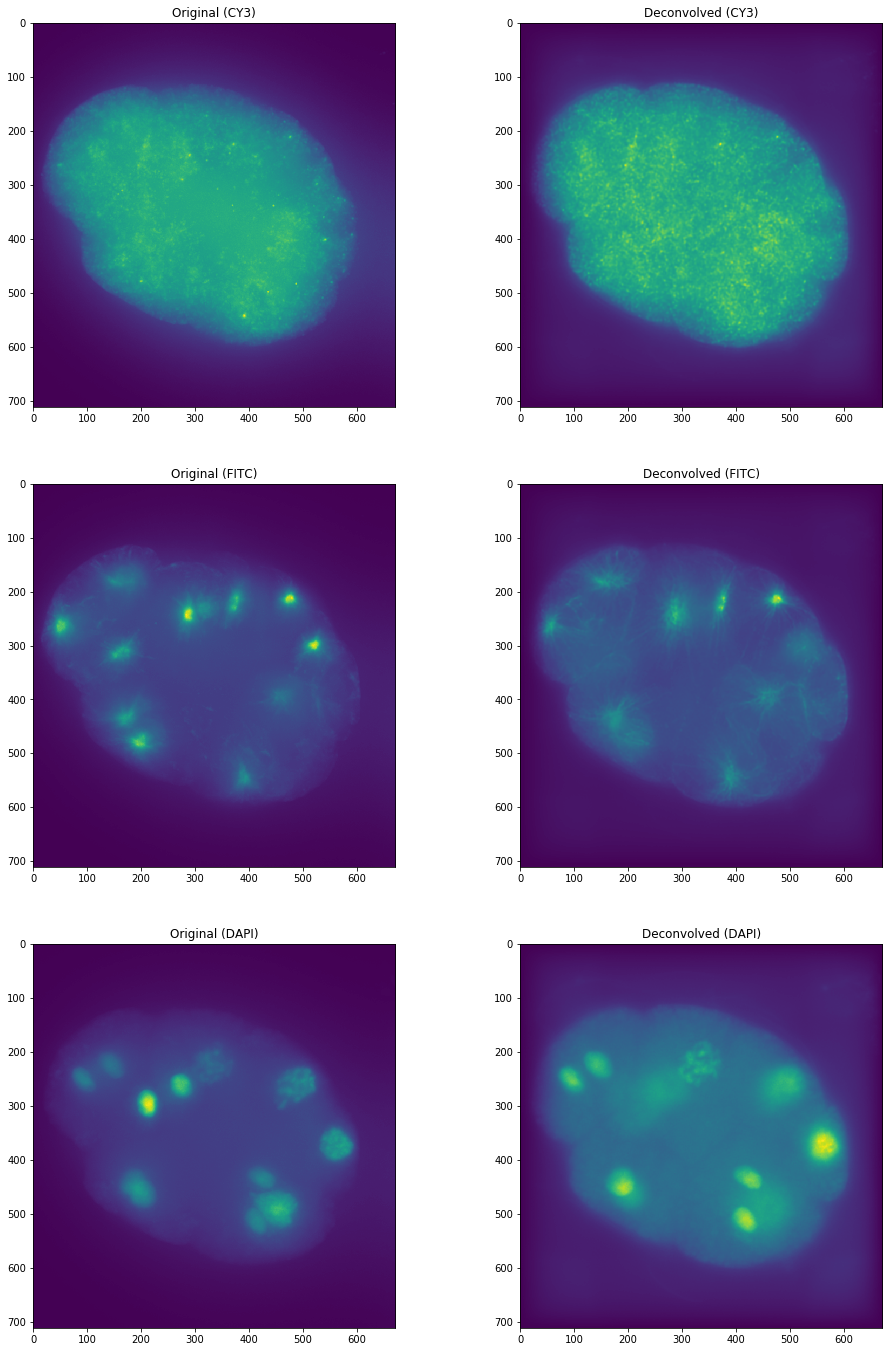

In [106]:
chs = acqs.keys()

fig, axs = plt.subplots(len(chs), 2)
fig.set_size_inches((16, 24))

for i, ch in enumerate(chs):
    axs[i][0].imshow(prep(img_rgb[:,:,:,i]))
    axs[i][0].set_title('Original ({})'.format(ch))
    axs[i][1].imshow(prep(res_rgb[:,:,:,i]))
    axs[i][1].set_title('Deconvolved ({})'.format(ch))